In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial, reduce
import ruamel.yaml
from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import min_error
from causal_optoconnectics.core import Connectivity
%matplotlib inline

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_3/')

In [9]:
def conditional_sum(s1, s2):
    l = [
        'yz_sum',
        'z_sum',
        'yx_sum',
        'x_sum',
        'yxinv_sum',
        'xinv_sum',
        'y0z_sum',
        'y0x_sum',
        'y0xinv_sum',
        'n_trials'
    ]
    if s1.name in l:
        return s1 + s2
    else:
        assert (s1 == s2).all()
        return s1
    
def compute_connectivity_from_sum(row):
    conn = Connectivity(
        compute_values=False,
        compute_sums=False
    )
    conn.__dict__.update(row.to_dict())
    conn.compute()
    result = conn.__dict__
    return result

In [5]:
n_iter = 100

In [12]:
paths = [path for path in data_path.iterdir() if path.is_dir()]
df = {path: defaultdict(list) for path in paths}
rng = default_rng()
values = pd.DataFrame()
pbar = tqdm(total=len(paths)*n_iter)
for path in paths:
    samples = [pd.read_csv(p) for p in path.glob('rank*.csv')]
    for ii in range(n_iter):
        idxs = rng.choice(len(samples), size=len(samples)-2, replace=False)
        sample = reduce(lambda  left, right: left.combine(right, conditional_sum), samples)
        sample = pd.DataFrame([
            compute_connectivity_from_sum(row)
            for i, row in sample.iterrows()])
        df[path]['error_beta_did'].append(min_error(sample, 'beta_did').fun)
        df[path]['error_beta_iv_did'].append(min_error(sample, 'beta_iv_did').fun)
        df[path]['error_beta'].append(min_error(sample, 'beta').fun)
        df[path]['error_beta_iv'].append(min_error(sample, 'beta_iv').fun)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sample = reduce(lambda  left, right: pd.combine(left, right, conditional_sum), samples)
sample = pd.DataFrame([
    compute_connectivity_from_sum(row)
    for i, row in sample.iterrows()])
sample.to_csv(row.path / 'sample.csv')
values = pd.concat((values, sample))
data_df.loc[i, 'error_beta_did'] = min_error(sample, 'beta_did').fun
data_df.loc[i, 'error_beta_iv_did'] = min_error(sample, 'beta_iv_did').fun
data_df.loc[i, 'error_beta'] = min_error(sample, 'beta').fun
data_df.loc[i, 'error_beta_iv'] = min_error(sample, 'beta_iv').fun

data_df.loc[:,'error_diff'] = data_df.error_beta - data_df.error_beta_iv
data_df.loc[:,'error_diff_did'] = data_df.error_beta_did - data_df.error_beta_iv_did

In [46]:
data_df = data_df.sort_values('sparsity')

Text(0, 0.5, '$\\mathrm{Error}$')

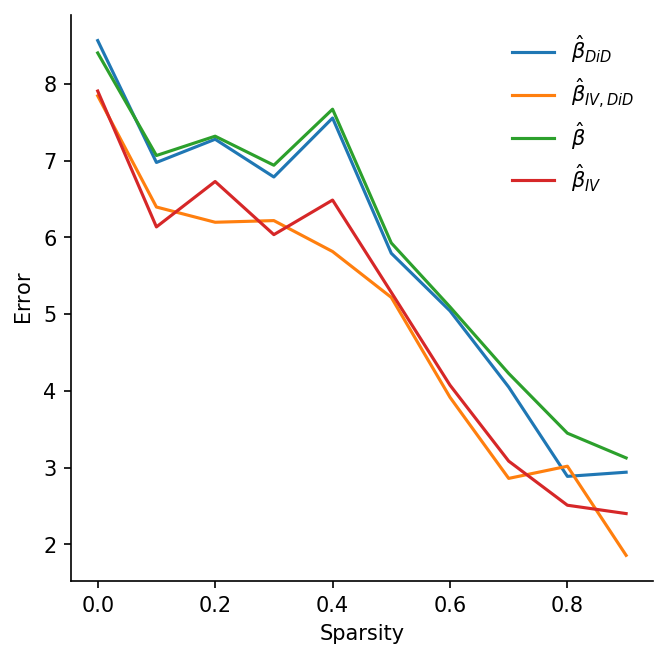

In [47]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(data_df.sparsity, data_df['error_beta_did'], label=r'$\hat{\beta}_{DiD}$')
ax.plot(data_df.sparsity, data_df['error_beta_iv_did'], label=r'$\hat{\beta}_{IV,DiD}$')

ax.plot(data_df.sparsity, data_df['error_beta'], label=r'$\hat{\beta}$')
ax.plot(data_df.sparsity, data_df['error_beta_iv'], label=r'$\hat{\beta}_{IV}$')

plt.legend(frameon=False)
sns.despine()
ax.set_xlabel('Sparsity')
ax.set_ylabel(r'$\mathrm{Error}$')